<IPython.core.display.Javascript object>


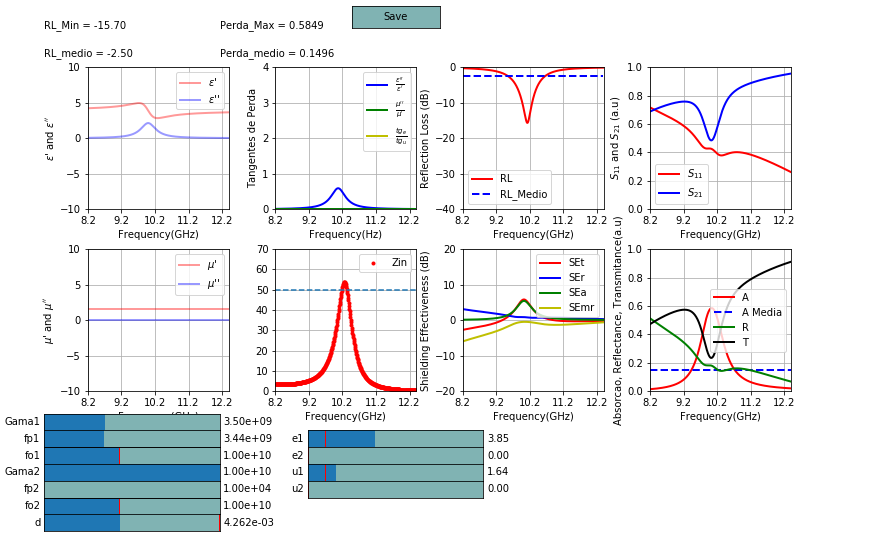

In [7]:
# -*- coding: utf-8 -*-
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as si
from matplotlib.widgets import Slider, Button, RadioButtons
#from matplotlib.ticker import MultipleLocator
import os

#%matplotlib inline
%matplotlib notebook # No Jupyter é necessário para funcionar

# Equação de Lorentz em função da Frequência
def e1(fo,fp,gama,f):
    return (2*np.pi)**2*fp**2*(fo**2-f**2)/((2*np.pi)**2*(fo**2-f**2)**2+f**2*(gama)**2)
def e2(fo,fp,gama,f): 
    return (2*np.pi*(fp**(2.0))*(gama*f))/((2*np.pi)**2*((fo**(2.0))-(f**(2.0)))**(2.0)+((gama)*f)**(2.0))
def u1(fo,fp,gama,f):
    return (2*np.pi)**2*fp**2*(fo**2-f**2)/((2*np.pi)**2*(fo**2-f**2)**2+f**2*(gama)**2)
def u2(fo,fp,gama,f): 
    return (2*np.pi*(fp**(2.0))*(gama*f))/((2*np.pi)**2*((fo**(2.0))-(f**(2.0)))**(2.0)+((gama)*f)**(2.0))


#Frequência
ini = 8.2e9 #Dependo da frequencia de CORTE!!!valor igual ou abaixo da Freq_corte, ele dá zero no gama0
fim = 12.4e9
inter = 0.01e9
frequencia = np.arange(ini,fim,inter)

#Plotar Frequencia Grafico
F_graf =[]
ini_graf = ini/1e9
fim_graf = fim/1e9
step_graf = 1


fo = 10e9 # Frequência de ressonância
eo= 8.85e-12 #Constante
fp = 10e9 # Frequência de Plasma
gama = 1e+10# Tempo de amortecimento
fo1=10*1e9 #GHz


#--------------------Par s21 e S21----------------------
d = 9.77e-3 #[m] Espessura da amostra
L1 = 0.0e-3 #[m] Plano de referência porta 1
L2 = 9.76e-3 - d #[m] Plano de referência porta 2
a = 22.86e-3 #[m] Base maior do guia de onda (X-Band)
#Propriedades
c = 2.998e8 #[m/s] Velocidade da luz
u0=4*np.pi*1e-7 # Permeabilidade do vácuo
freq_corte = 6.56e9 #[Hz] Frequência de Corte (X-Band) #GOVERNA A FREQUENCIA MINIMAAAAAAA DENTRO DO GUIA DE ONDA!!!!
onda_cut = c/freq_corte #[m] lambda de corte
#-------------------------------------------------------




# Offset Inicial - Real e Imaginário
e1_offset = 1
e2_offset = 0
u1_offset = 1
u2_offset = 0
e1_sv=[]
e2_sv=[]
u1_sv =[]#Dependente de epsilon
u2_sv =[]#Dependente de epsilon


#Tangente de Perna
tg_e=[]
tg_u=[]


const_miguel = []
#coef_R = []

#gamma = [] # Formula Baldan



# Modelo Linha de Transmissao - Curto
Zin = [] #Impedancia
S11 =[] # RL(dB)
S11_LINEAR =[] # RL(a.u)

#Par - S
s11c =[]
s21c=[]

# Absorbance, Reflectance, Transmitance
AA =[] #A = 1 - R - T (Absorbancia)
RR = [] # R (Reflectancia)
TT =[] #T (Transmitancia)


#Shielding Effectiveness total
SEt =[]
#Shielding Absorbing
SEa =[]
#Shielding Reflected
SEr =[]
#Shielding Multiples Reflections
SEmr=[]


for f in frequencia:

    F_graf.append(f/1e9)
    
    e1_s = e1(fo1,fp,gama,f) + e1_offset
    e2_s = e2(fo1,fp,gama,f) + e2_offset

    u1_s = u1(fo1,fp,gama,f) + u1_offset
    u2_s = u2(fo1,fp,gama,f) + u2_offset

    e1_sv.append(e1_s)
    e2_sv.append(e2_s)	
    u1_sv.append(u1_s)
    u2_sv.append(u2_s)

    const_miguel.append((e2_s/e1_s)/(u2_s/u1_s))

    #tg_perda = (u1_s*e2_s + u2_s*e1_s)/(u1_s*e1_s - u2_s*e2_s) #Formula Net
    #tg.append(tg_perda)
    #gamma.append((u.imag/e2_s)/(u.real/e1_s)) #Formula Baldan

    tg_e.append(e2_s/e1_s)#tg perda epsilon
    tg_u.append(u2_s/u1_s)#tg perda Mu
    #TIVER QUE FAZER ISSO PRA RESOLVER O BUG DO ZIN QUANDO EPSILON OU MU DÁ NEGATIVO!!!!!
    if e1_s < 0:
        e1_s = e1_s*(-1)

    if e2_s < 0:
        e2_s = e2_s*(-1)
        

    if u1_s < 0:
        u1_s = u1_s*(-1)


    if u2_s < 0:
        u2_s = u2_s*(-1)

    ############################################################################################
    

    #u1_v.append(u.real)
    #u2_v.append(u.imag)
    
    
    
    #Calcular Zin-----------------------------
    
    e = e1_s - e2_s*1j
    u = u1_s - u2_s*1j
    
    z = (50*(u/e)**(0.5))*np.tanh(1j*(2*np.pi*d*f/c)*((u*e)**(0.5))) #COM TANH
    #Coeficiente de Reflexão
    R = (z-50)/(z+50)
    #Linear Mag
    s11 = abs(R)
    S11_LINEAR.append(s11)
    #Passar para S11(dB)
    db = 20*np.log10(s11)
    #S11.append(s11)# LINEAR
    S11.append(db) # dB

    #Impedancia Input
    Zin.append(z)
    #Coeficiente de Refelxao
    #coef_R.append(R)

    #-----------------------------------------

    #-------------------------TEÓRICO - ANALÍTICO----------------------------------
    #lambda zero = comprimento de onda no vácuo
    onda = c/(f) # [m]
    #Constante de propagacao da onda no espaco livre
    gama0 = (2j*np.pi)*np.sqrt((1.0)/(onda**(2.0))-(1.0)/(onda_cut**(2.0))) #ESSE TERMO DA ZERO, QUANDO FREQUENCIA TEM VALOR = FRE_CUT
    #Constante de propagacao da onda no material
    gamaX = (2j*np.pi/onda)*np.sqrt(e*u-(onda**2.0)/(onda_cut**2.0))
    #Impedância analítica do vácuo
    z_a0= (1j*u0*2*np.pi*f)/(gama0)
    #----------------- sem normalizar pra 50ohms----------------------
    #impedancia Analitica do Material
    #z_ma = 50*((1j*2*np.pi*f*u*u0)/(gamaX))/(z_a0) #z_a0 normliza
    #Coeficiente de Refelxao Analitico
    #ra = (z_ma-50)/(z_ma+50)
    #-----------------------------------------------------------------	
    #impedancia Analitica do Material
    z_ma = ((1j*2*np.pi*f*u*u0)/(gamaX))/(z_a0) #z_a0 normliza
    #Coeficiente de Refelxao Analitico
    ra = (z_ma-1)/(z_ma+1)
    #Coeficiente de transmissao Analitico
    ta = np.exp(-gamaX*d)
    #-------------------------------------------------------------------

    #CONSTANTES DE AJUSTE DA REFERÊNCIA NAS PORTAS
    R1 = np.exp(1*gama0*L1) #constantes
    R2 = np.exp(1*gama0*L2) #constantes

    #**************************************************************
    #FONTE: Página 9, livro: NIST - NRW
    #PARAMETRO-S ANALITICO-----------------------------------------
    s11c_colocar = R1*R1*((ra*(1-ta**2))/(1-(ra**2)*(ta**2))) 
    s21c_colocar = R2*R1*((ta*(1-ra**2))/(1-(ra**2)*(ta**2)))

    #Guardar no Vetor - CORRIGIDO
    s11c.append(abs(s11c_colocar)) #add vetor s11 
    s21c.append(abs(s21c_colocar)) #add vetor s21

    #Perda A = 1 - R - T
    AA.append(1 - abs(s11c_colocar)**2 - abs(s21c_colocar)**2)
    RR.append(abs(s11c_colocar)**2)
    TT.append(abs(s21c_colocar)**2)

    #Shielding
    ser = 10*np.log10(1/(1-abs(s11c_colocar)**2.0))
    sea = 10*np.log10((1-abs(s11c_colocar)**2)/(abs(s21c_colocar)**2.0))
    semr =20*np.log10(abs(1-(abs(s11c_colocar)**2.0)*10**(-sea/10))) # Desprezivel quando SEa >10 dB
    se = ser + sea + semr

    SEr.append(ser)
    SEa.append(sea)
    SEmr.append(semr)
    SEt.append(se)





#------------------------------------Gráficos-------------------------------------------------


# ax1=plt.subplot(441) -> Explicação (lin, col, pos)

# x = número de linhas de gráfico que existirão
# col = número de colunas de gráficos que existirão
# pos = sabendo  número de linhas e colunas, você saberá quantos gráficos poderá fazer... 

#exemplo (221) => poderemos ter no total 4 gráficos (2x2), e esse se encontra na primeira posição (1)
#exemplo (224) => poderemos ter no total 4 gráficos (2x2), e esse se encontra na última posição (4)



#Arrumar Gráficos
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.33, hspace=0.28)

# Gráfico 1 - Parte REAL and Imaginary - Epsilon
ax1=plt.subplot(241)

plt.subplots_adjust(left=0.1, bottom=0.3)
k, =plt.plot(F_graf,e1_sv,'r-',alpha = 0.4,linewidth=2,label="$\epsilon$'") # Real Lorentz
k1,=plt.plot(F_graf,e2_sv,'b-',alpha=0.4,linewidth = 2,label="$\epsilon$''") # Imaginary Lorentz
plt.xlabel('Frequency(GHz)')
plt.ylabel("$\epsilon$' and $\epsilon''$")
plt.ylim(-10,10)
#plt.xlim(ini,fim)
plt.xlim(ini_graf,fim_graf)
plt.xticks(np.arange(ini_graf, fim_graf, step=step_graf ))
plt.legend()
plt.grid(True)

# Gráfico 1 - Parte REAL and Imaginary - Mu
ax1=plt.subplot(245)

plt.subplots_adjust(left=0.1, bottom=0.3)
mu, =plt.plot(F_graf,u1_sv,'r-',alpha = 0.4,linewidth=2,label="$\mu$'") # Real Lorentz
mu1,=plt.plot(F_graf,u2_sv,'b-',alpha=0.4,linewidth = 2,label="$\mu$''") # Imaginary Lorentz
plt.xlabel('Frequency(GHz)')
plt.ylabel("$\mu$' and $\mu''$")
plt.ylim(-10,10)
#plt.xlim(ini,fim)
plt.xlim(ini_graf,fim_graf)
plt.xticks(np.arange(ini_graf, fim_graf, step=step_graf ))
plt.legend()
plt.grid(True)

# Gráfico 2 - Tangente de Perda
ax2=plt.subplot(242)
#t, =plt.plot(F_graf,tg,'r-',linewidth=2,label= r"$\frac{\mu' \epsilon'' + \mu'' \epsilon'}{\mu' \epsilon' - \mu'' \epsilon''}$")
te1, =plt.plot(F_graf,tg_e,'b-',linewidth=2,label= r"$\frac{\epsilon''}{\epsilon'}$")
tu1, =plt.plot(F_graf,tg_u,'g-',linewidth=2,label= r"$\frac{\mu''}{\mu'}$")
mig, =plt.plot(F_graf,const_miguel,'y-',linewidth=2,label = r"$\frac{tg_{e}}{tg_{u}}$")
#aa, = plt.plot(F_graf, gamma, 'y-',linewidth = 2, label = r"$\gamma$")
plt.xlabel('Frequency(Hz)')
plt.ylabel("Tangentes de Perda")
plt.ylim(0,4)
#plt.xlim(ini,fim)
plt.xlim(ini_graf,fim_graf)
plt.xticks(np.arange(ini_graf, fim_graf, step=step_graf ))
plt.legend()
plt.grid(True)


# Gráfico 3 - RL
ax3=plt.subplot(243)
xx, =plt.plot(F_graf,S11,'r-',linewidth=2,label='RL')
xxm, =plt.plot(F_graf,[np.mean(S11)]*len(frequencia),'b--',linewidth=2,label='RL_Medio')
plt.xlabel('Frequency(GHz)')
plt.ylabel('Reflection Loss (dB)')
plt.ylim(-40,0)
#plt.xlim(ini,fim)
plt.xlim(ini_graf,fim_graf)
plt.xticks(np.arange(ini_graf, fim_graf, step=step_graf ))
plt.legend()
plt.grid(True)

#Grafico 7 Shielding effectiveness total
ax3=plt.subplot(247)
xxl, =plt.plot(F_graf,SEt,'r-',linewidth=2,label='SEt')
xxxl, =plt.plot(F_graf,SEr,'b-',linewidth=2,label='SEr')
xxxxl, =plt.plot(F_graf,SEa,'g-',linewidth=2,label='SEa')
xxxxxl, =plt.plot(F_graf,SEmr,'y-',linewidth=2,label='SEmr')
plt.xlabel('Frequency(GHz)')
plt.ylabel('Shielding Effectiveness (dB)')
plt.ylim(-20,+20)
#plt.xlim(ini,fim)
plt.xlim(ini_graf,fim_graf)
plt.xticks(np.arange(ini_graf, fim_graf, step=step_graf ))
plt.legend()
plt.grid(True)


# Gráfico 4 - S11 e S21
ax4=plt.subplot(244)
yy, =plt.plot(F_graf,s11c,'r-',linewidth=2,label='$S_{11}$')
zz, =plt.plot(F_graf,s21c,'b-',linewidth=2,label='$S_{21}$')
plt.xlabel('Frequency(GHz)')
plt.ylabel('$S_{11}$ and $S_{21}$ (a.u)')
plt.ylim(0,1)
#plt.xlim(ini,fim)
plt.xlim(ini_graf,fim_graf)
plt.xticks(np.arange(ini_graf, fim_graf, step=step_graf ))
plt.legend()
plt.grid(True)

# Gráfico 5 - S11 e S21 - Perda (A = 1 - R - T)
ax5=plt.subplot(248)
pp, =plt.plot(F_graf,AA,'r-',linewidth=2,label='A')
ppm, =plt.plot(F_graf,[np.mean(AA)]*len(frequencia),'b--',linewidth=2,label='A Media') #************
ppr,=plt.plot(F_graf,RR,'g-',linewidth =2,label="R")
ppt,=plt.plot(F_graf,TT,'black',linewidth=2,label="T")
plt.xlabel('Frequency(GHz)')
plt.ylabel('Absorcao, Reflectance, Transmitance(a.u)')
plt.ylim(0,1)
#plt.xlim(ini,fim)
plt.xlim(ini_graf,fim_graf)
plt.xticks(np.arange(ini_graf, fim_graf, step=step_graf ))
plt.legend()
plt.grid(True)

# Gráfico 6 - impedancia
ax6=plt.subplot(246)
zinn, =plt.plot(F_graf,Zin,'r.',linewidth=2,label='Zin')
zinn50, = plt.plot(F_graf,[50]*len(frequencia), '--')
#RR, = plt.plot(frequencia, coef_R, label = 'coeficiente_Reflexao')
#ppm, =plt.plot(frequencia,[np.mean(Perda)]*len(frequencia),'b--',linewidth=2,label='Perda_medio')
plt.xlabel('Frequency(GHz)')
#plt.ylabel('Absorcao(a.u)')
plt.ylim(0,70)
#plt.xlim(ini,fim)
plt.xlim(ini_graf,fim_graf)
plt.xticks(np.arange(ini_graf, fim_graf, step=step_graf ))
plt.legend()
plt.grid(True)

"""

# Gráfico 12 - Diagrama de Nyquist -permissividade
ax1=plt.subplot(445)

plt.subplots_adjust(left=0.1, bottom=0.3)
Ne, =plt.plot(e1_sv,e2_sv,'r-',alpha = 0.4,linewidth=2,label="Diagrama de Nyquist") # Real Lorentz

plt.xlabel("$\epsilon$'")
plt.ylabel("$\epsilon''$")

plt.legend()
plt.grid(True)

# Gráfico 13 - Diagrama de Nyquist - permeabilidade

ax1=plt.subplot(4,4,13) # número com 2 casas decimal, tem que colocar vírgula

plt.subplots_adjust(left=0.1, bottom=0.3)
Nu, =plt.plot(u1_sv,u2_sv,'r-',alpha = 0.4,linewidth=2,label="Diagrama de Nyquist") # Real Lorentz

plt.xlabel("$\mu$'")
plt.ylabel("$\mu''$")

plt.legend()
plt.grid(True)
"""




#--------------------------------Textos dos Gráficos------------------------------------------


#tangente de perda eletrica
#tg_p = float(np.mean(tg))
# transform -> joga o texto pra fora do grafc
#tg_perda_text = plt.text(0.55, 0.22, r"$\frac{\mu' \epsilon'' + \mu'' \epsilon'}{\mu' \epsilon' - \mu'' \epsilon''}$= %.2f"%tg_p, fontsize=14, transform=plt.gcf().transFigure) #Transform = .... é para tirar de dentro do gráfico o texto

#New Coeficiente
#gamma_calc = (np.mean(u2_v)/np.mean(e2_sv))/(np.mean(u1_v)/np.mean(e1_sv))
#gamma_text = plt.text(0.55, 0.30, r"$\frac{\frac{\mu''}{\epsilon''}}{\frac{\mu'}{\epsilon'}}$= %.2f"%gamma_calc, fontsize=14, transform=plt.gcf().transFigure) 


#Menor RL
RL_min = plt.text(0.05, 0.95, "RL_Min = %.2f"%min(S11), fontsize=10, transform=plt.gcf().transFigure) 
#Média_RL
RL_m = plt.text(0.05, 0.9, "RL_medio = %.2f"%np.mean(S11), fontsize=10, transform=plt.gcf().transFigure) 

#Maior Absor
Perda_max = plt.text(0.25, 0.95, "A_Max = %.2f"%max(AA), fontsize=10, transform=plt.gcf().transFigure)
#Média_Absor 
Perda_m = plt.text(0.25, 0.90, "A_medio = %.2f"%np.mean(AA), fontsize=10, transform=plt.gcf().transFigure)


# --------------------------------Parte Interativa do Programa ------------------------------------------------
axcolor = (0.5,0.7,0.7)

# Offset Real e Imaginário - Epsilon
e1_int = 1
e2_int = 0
e1_ = plt.axes([0.35, 0.20, 0.2, 0.03], axisbg=axcolor)
e1bar = Slider(e1_, 'e1', 0, 10, valinit=e1_int)
e2_ = plt.axes([0.35, 0.17, 0.2, 0.03], axisbg=axcolor)
e2bar = Slider(e2_, 'e2', 0, 10, valinit=e2_int)

# Offset Real e Imaginário - Mu
u1_int = 1
u2_int = 0
u1_ = plt.axes([0.35, 0.14, 0.2, 0.03], axisbg=axcolor)
u1bar = Slider(u1_, 'u1', 0, 10, valinit=u1_int)
u2_ = plt.axes([0.35, 0.11, 0.2, 0.03], axisbg=axcolor)
u2bar = Slider(u2_, 'u2', 0, 10, valinit=u2_int)

#----------------------------------ELETRICA-----------------------------
# Frequencia de Resonância
fo_1 = plt.axes([0.05, 0.17, 0.2, 0.03], axisbg=axcolor)#(pos(x da barra),pos(y da barra),comprimento,largura)
fobar1= Slider(fo_1, 'fo1', 8.2e9, 12.4e9, valinit=fo1, valfmt='%.2e')

# Tempo de amortecimento
gama_1 = plt.axes([0.05, 0.23, 0.2, 0.03], axisbg=axcolor)
gamabar1= Slider(gama_1, 'Gama1', 1e5, 1e10, valinit=gama, valfmt='%.2e')

# Frequência de Plasma
fp_1  = plt.axes([0.05, 0.20, 0.2, 0.03], axisbg=axcolor)
fpbar1 = Slider(fp_1, 'fp1', 1e4, 1e10, valinit= fp, valfmt='%.2e')

#----------------------------------MAGNÉTICA-----------------------------
# Frequencia de Resonância
fo_2 = plt.axes([0.05, 0.08, 0.2, 0.03], axisbg=axcolor)#(pos(x da barra),pos(y da barra),comprimento,largura)
fobar2= Slider(fo_2, 'fo2', 8.2e9, 12.4e9, valinit=fo1, valfmt='%.2e')

# Tempo de amortecimento
gama_2 = plt.axes([0.05, 0.14, 0.2, 0.03], axisbg=axcolor)
gamabar2= Slider(gama_2, 'Gama2', 1e5, 1e10, valinit=gama, valfmt='%.2e')

# Frequência de Plasma
fp_2  = plt.axes([0.05, 0.11, 0.2, 0.03], axisbg=axcolor)
fpbar2 = Slider(fp_2, 'fp2', 1e4, 1e10, valinit= fp, valfmt='%.2e')


# Espessura
d_ = plt.axes([0.05, 0.05, 0.2, 0.03], axisbg=axcolor)
dbar= Slider(d_, 'd', 0e-3, 9.8e-3, valinit=d, valfmt='%.3e')
#----------------------------------------------------------------------------------------------------------------


# Botão Save
savex = plt.axes([0.40, 0.95, 0.1, 0.04])
buttonsave = Button(savex, 'Save', color=axcolor, hovercolor='0.975')

count = 0
def save(event):
    
    #PARA DAR CERTO, TIVE QUE COLOCAR OS VALORES COMO GLOBAL NA FUNÇÃO DE CÁLCULO	
    nome = "./teorico_lorentz_"+str(round(d*1e3,2))+"mm_"+str(count)+"_"
    new = open(nome+".txt", 'w')
    new.write("%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\n"%("f(GHz)","e'",'e"',"u'",'u"','tan_e','tan_u',"RL","RL_med","Zin","S11","S21","A","R","T",'SEt','SEr','SEa','SEmr'))
    plt.savefig(nome+'.png')

    for i in range(0,len(frequencia)):

        escrever = "%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\n"%(frequencia[i]/1e9,e1_sv[i],e2_sv[i],u1_sv[i],u2_sv[i],tg_e[i],tg_u[i],S11[i],np.mean(S11),Zin[i],s11c[i],s21c[i],AA[i],RR[i],TT[i],SEt[i],SEr[i],SEa[i],SEmr[i]) 
        new.write(escrever)
    new.close()
    #global count
    count +=1

buttonsave.on_clicked(save)

def update1(val):

    frequencia = np.arange(ini,fim,inter)	

    #Permissividade e Permeabilidade	
    global e1_sv,e2_sv,u1_sv,u2_sv
    e1_sv = []
    e2_sv = []	
    u1_sv = []
    u2_sv = []

    #Tangente de Perda
    global tg_e,tg_u
    tg_e = []
    tg_u = []

    #global tg
    #tg = []


    #global coef_R
    #coef_R =[]

    # Reflection Loss (RL)
    global Zin,S11,S11_LINEAR
    Zin = []	
    S11 = []
    S11_LINEAR = []


    #Par-S (S11 e S21)
    global s11c,s21c
    s11c =[]
    s21c =[]

    #Absorbancia, Reflectancia e Transmitancia (A = 1 - R - T)
    global AA,RR,TT
    AA =[]
    RR =[]
    TT =[]

    #Shielding Effectiveness (SEt = SEr+SEa+SEmr)
    global SEt
    SEt =[]
    global SEa
    SEa =[]
    global SEr
    SEr =[]
    global SEmr
    SEmr=[]


    #global u1
    #u1_v =[]
    #global u2
    #u2_v =[]

    #global gamma
    #gamma = []
    global const_miguel
    const_miguel =[]



    # Atualizar outros	
    gama1 = gamabar1.val
    fo1 = fobar1.val
    fp1 = fpbar1.val
    global d #******************************************
    d = dbar.val
    L2 = 9.76e-3 - d

    #Magnetica
    gama2 = gamabar2.val
    fo2 = fobar2.val
    fp2 = fpbar2.val


    # Offset real e imaginario - Atualizar
    e1_offset=e1bar.val
    e2_offset=e2bar.val
    u1_offset=u1bar.val
    u2_offset=u2bar.val
    for f in frequencia:


        # ELETRICA E MAGNETICA DIFERENTES		
        e1_s = e1(fo1,fp1,gama1,f) + e1_offset
        e2_s = e2(fo1,fp1,gama1,f) + e2_offset
        u1_s = u1(fo2,fp2,gama2,f) + u1_offset
        u2_s = u2(fo2,fp2,gama2,f) + u2_offset
        """
        # ELETRICA E MAGNETICA IGUAIS		
        e1_s = e1(fo1,fp1,gama1,f) + e1_offset
        e2_s = e2(fo1,fp1,gama1,f) + e2_offset
        u1_s = u1(fo1,fp1,gama1,f) + u1_offset
        u2_s = u2(fo1,fp1,gama1,f) + u2_offset
        """

        e1_sv.append(e1_s)
        e2_sv.append(e2_s)
        u1_sv.append(u1_s)
        u2_sv.append(u2_s)

        const_miguel.append((e2_s/e1_s)/(u2_s/u1_s))

        #tg.append((u1_s*e2_s + u2_s*e1_s)/(u1_s*e1_s - u2_s*e2_s))
        #gamma.append((u2_s/e2_s)/(u1_s/e1_s))
        tg_e.append(e2_s/e1_s)
        tg_u.append(u2_s/u1_s)



        #TIVER QUE FAZER ISSO PRA RESOLVER O BUG DO ZIN QUANDO EPSILON OU MU DÁ NEGATIVO!!!!!
        if e1_s < 0:
            e1_s = e1_s*(-1)

        if e2_s < 0:
            e2_s = e2_s*(-1)


        if u1_s < 0:
            u1_s = u1_s*(-1)


        if u2_s < 0:
            u2_s = u2_s*(-1)

        ############################################################################################


        #Calcular Zin-----------------------------

        e = e1_s - e2_s*1j
        #u = u1 - u2*1j
        u = u1_s - u2_s*1j
        z = (50*(u/e)**(0.5))*np.tanh(1j*(2*np.pi*d*f/c)*((u*e)**(0.5))) #COM TANH

        #Coeficiente de Reflexão
        R = (z-50)/(z+50)
        #Linear Mag
        s11 = abs(R)
        S11_LINEAR.append(s11)
        #Passar para S11(dB)
        db = 20*np.log10(s11)
        #S11.append(s11)# LINEAR
        S11.append(db) # dB

        #Impedância Input
        Zin.append(z)
        #Coeficiente de Refelxao
        #coef_R.append(R)
        #-----------------------------------------


        #-------------------------TEÓRICO - ANALÍTICO----------------------------------
        #lambda zero = comprimento de onda no vácuo
        onda = c/(f) # [m]
        #Constante de propagacao da onda no espaco livre
        gama0 = (2j*np.pi)*np.sqrt((1.0)/(onda**(2.0))-(1.0)/(onda_cut**(2.0)))
        #Constante de propagacao da onda no material
        gamaX = (2j*np.pi/onda)*np.sqrt(e*u-(onda**2.0)/(onda_cut**2.0))
        #Impedância analítica do vácuo
        z_a0= (1j*u0*2*np.pi*f)/(gama0)
        #impedancia Analitica do Material
        z_ma = ((1j*2*np.pi*f*u*u0)/(gamaX))/(z_a0) #z_a0 normliza
        #Coeficiente de Refelxao Analitico
        ra = (z_ma-1)/(z_ma+1)
        #Coeficiente de transmissao Analitico
        ta = np.exp(-gamaX*d)
        #-------------------------------------------------------------------

        #CONSTANTES DE AJUSTE DA REFERÊNCIA NAS PORTAS
        R1 = np.exp(1*gama0*L1) #constantes
        R2 = np.exp(1*gama0*L2) #constantes

        #**************************************************************
        #FONTE: Página 9, livro: NIST - NRW
        #PARAMETRO-S ANALITICO-----------------------------------------
        s11c_colocar = R1*R1*((ra*(1-ta**2))/(1-(ra**2)*(ta**2))) 
        s21c_colocar = R2*R1*((ta*(1-ra**2))/(1-(ra**2)*(ta**2)))

        #Guardar no Vetor - CORRIGIDO
        s11c.append(abs(s11c_colocar)) #add vetor s11 
        s21c.append(abs(s21c_colocar)) #add vetor s21

        #Perda
        AA.append(1 - abs(s11c_colocar)**2 - abs(s21c_colocar)**2 )
        RR.append(abs(s11c_colocar)**2)
        TT.append(abs(s21c_colocar)**2)

        ser = 10*np.log10(1/(1-abs(s11c_colocar)**2.0))
        sea = 10*np.log10((1-abs(s11c_colocar)**2)/(abs(s21c_colocar)**2.0))
        semr =20*np.log10(abs(1-(abs(s11c_colocar)**2.0)*10**(-sea/10))) # Desprezivel quando SEa >10 dB
        se = ser + sea + semr

        SEr.append(ser)
        SEa.append(sea)
        SEmr.append(semr)
        SEt.append(se)




    #Update Texto
    #tg_p = float(np.mean(tg))
    #tg_perda_text.set_text(r"$\frac{\mu' \epsilon'' + \mu'' \epsilon'}{\mu' \epsilon' - \mu'' \epsilon''}$= %.2f"%tg_p)

    #gamma_calc = (np.mean(u2_sv)/np.mean(e2_sv))/(np.mean(u1_sv)/np.mean(e1_sv))
    #gamma_text.set_text(r"$\frac{\frac{\mu''}{\epsilon''}}{\frac{\mu'}{\epsilon'}}$= %.2f"%gamma_calc)

    RL_min.set_text("RL_Min = %.2f"%min(S11))
    RL_m.set_text("RL_medio = %.2f"%np.mean(S11))

    Perda_max.set_text("Perda_Max = %.4f"%max(AA))
    Perda_m.set_text("Perda_medio = %.4f"%np.mean(AA))

    #Update Graficos
    k.set_ydata(e1_sv)
    k1.set_ydata(e2_sv)

    #Nyquist	
    #Ne.set_ydata(e2_sv)
    #Ne.set_xdata(e1_sv)
    #mu.set_ydata(u1_v)
    #mu1.set_ydata(u2_v)
    #Nu.set_ydata(u2_sv)
    #Nu.set_xdata(u1_sv)

    mu.set_ydata(u1_sv)
    mu1.set_ydata(u2_sv)
    #t.set_ydata(tg)
    mig.set_ydata(const_miguel)
    te1.set_ydata(tg_e)
    tu1.set_ydata(tg_u)
    #aa.set_ydata(gamma)
    xx.set_ydata(S11)
    xxm.set_ydata([np.mean(S11)]*len(frequencia))
    xxl.set_ydata(SEt)
    xxxl.set_ydata(SEr)
    xxxxl.set_ydata(SEa)
    xxxxxl.set_ydata(SEmr)
    yy.set_ydata(s11c)
    zz.set_ydata(s21c)
    # A = 1 - R - T
    pp.set_ydata(AA)
    ppr.set_ydata(RR)
    ppt.set_ydata(TT)

    ppm.set_ydata([np.mean(AA)]*len(frequencia))
    zinn.set_ydata(Zin)
    #RR.set_ydata(coef_R)
    plt.draw()

gamabar1.on_changed(update1)
fobar1.on_changed(update1)
fpbar1.on_changed(update1)
e1bar.on_changed(update1)
e2bar.on_changed(update1)
u1bar.on_changed(update1)
u2bar.on_changed(update1)
dbar.on_changed(update1)

#Magnetica
gamabar2.on_changed(update1)
fobar2.on_changed(update1)
fpbar2.on_changed(update1)

plt.show()